In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
import pandas as pd

# Load the dataset
df = pd.read_csv('reviews.csv')

# Check for null values in the DataFrame
null_counts = df.isnull().sum()

# Display the count of null values for each column
print("Null Value Counts:")
print(null_counts)


Null Value Counts:
product     0
rating      0
review     10
dtype: int64


In [19]:
df_cleaned = df.dropna()

In [20]:
null_counts = df_cleaned.isnull().sum()

# Display the count of null values for each column
print("Null Value Counts:")
print(null_counts)

Null Value Counts:
product    0
rating     0
review     0
dtype: int64


In [21]:
# Convert cleaned DataFrame to CSV file
df_cleaned.to_csv('cleaned_reviews.csv', index=False)

print("Cleaned DataFrame has been saved to cleaned_reviews.csv")


Cleaned DataFrame has been saved to cleaned_reviews.csv


In [22]:
!pip install nltk
!pip install textblob
!pip install wordcloud

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
df = pd.read_csv("cleaned_reviews.csv", sep=",")
df.head()

,product,rating,review
0,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,I like how clean it makes my mouth feel! I did...
1,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,Bought this product to do Oil Pulling as that ...
2,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,How I found item: I noticed TikTok advertiseme...
3,Best Sellerin MouthwashesGuruNanda Coconut Oil...,4,I've done lots of oil pulling with pure coconu...
4,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,It's only been less than two weeks and I've no...


In [24]:
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [25]:
df = text_preprocessing(df, "review")

In [26]:
df["review"].head()

0    like clean make mouth feel notice whitening te...
1    bought product oil pulling meant ive oil pulli...
2    found item noticed tiktok advertisement floati...
3    ive done lot oil pulling pure coconut oil wint...
4    le two week ive noticed sensitivity already go...
Name: review, dtype: object

In [31]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]

  if barplot:
    # Bar Plot
    tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
    plt.title("Calculation of Term Frequencies : barplot")
    plt.show()

  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[20, 20])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calculation of Term Frequencies : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")

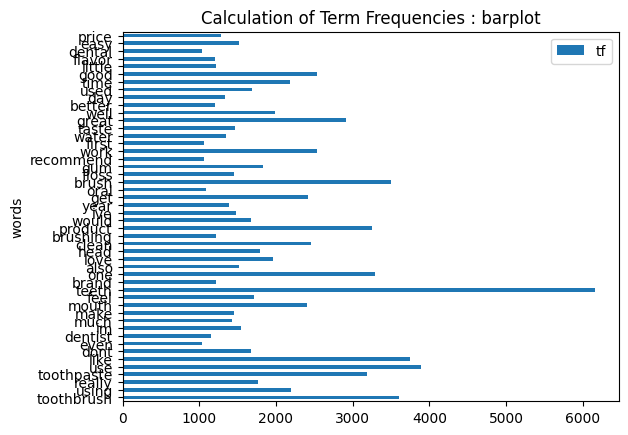

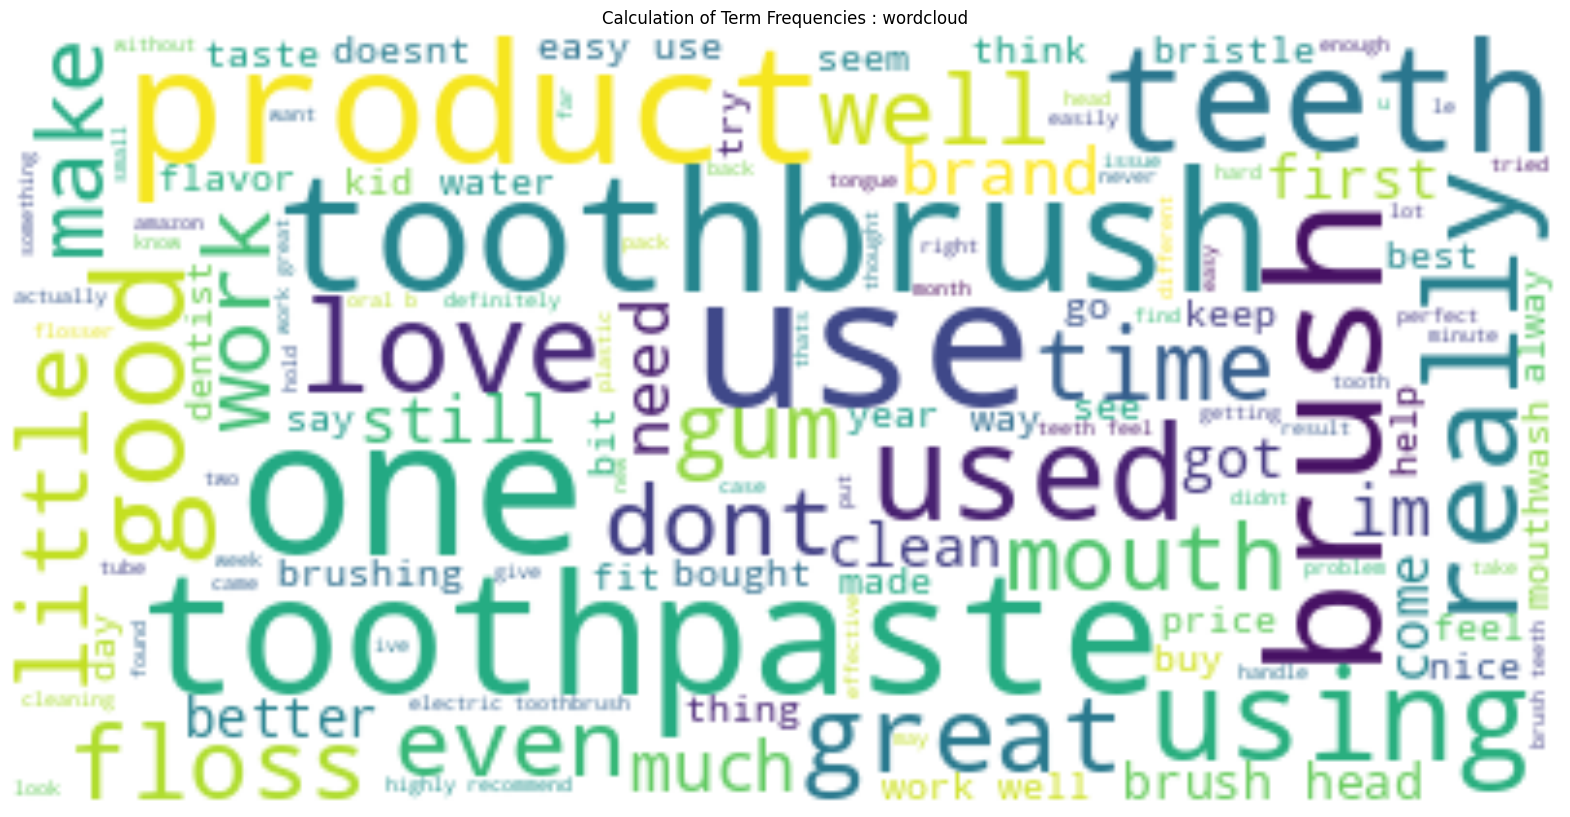

In [32]:
text_visulaization(df, "review")

Sentiment Analysis

In [33]:
def create_polarity_scores(dataframe, dependent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe["polarity_score"] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])

In [34]:
create_polarity_scores(df, "review")

In [35]:
df.head()

,product,rating,review,polarity_score
0,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,like clean make mouth feel notice whitening te...,0.81
1,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,bought product oil pulling meant ive oil pulli...,0.99
2,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,found item noticed tiktok advertisement floati...,0.98
3,Best Sellerin MouthwashesGuruNanda Coconut Oil...,4,ive done lot oil pulling pure coconut oil wint...,0.97
4,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,le two week ive noticed sensitivity already go...,0.59


In [36]:
# Create Lables
def create_label(dataframe, dependent_var, independent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
  dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

  X = dataframe[dependent_var]
  y = dataframe[independent_var]

  return X, y

In [37]:
X, y = create_label(df, "review", "sentiment_label")

In [38]:
# Split Dataset
def split_dataset(dataframe, X, y):
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y

In [39]:
train_x, test_x, train_y, test_y = split_dataset(df, X, y)


In [40]:
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer()
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [41]:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [42]:
def create_features_TFIDF_word(train_x, test_x):
  # TF-IDF word
  tf_idf_word_vectorizer = TfidfVectorizer()
  x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
  x_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word

In [43]:
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [44]:
def create_features_TFIDF_ngram(train_x, test_x):
  # TF-IDF ngram
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3))
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram

In [45]:
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)

In [46]:
def create_features_TFIDF_chars(train_x, test_x):
  # TF-IDF Characters
  tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
  x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(train_x)
  x_test_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_chars, x_test_tf_idf_chars

In [47]:
x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)

Sentiment Analysis - Create Model

In [48]:
# Logistic Regression
def crate_model_logistic(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  loj_count = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_count = loj_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  loj_word = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_word = loj_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  loj_ngram = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_ngram = loj_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  loj_chars = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_chars = loj_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(loj_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars

In [49]:
loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars = crate_model_logistic(train_x, test_x)

Accuracy - Count Vectors: 0.884
Accuracy - TF-IDF Word: 0.869
Accuracy TF-IDF ngram: 0.869
Accuracy TF-IDF Characters: 0.874


In [50]:
# Random Forest
def crate_model_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_count = RandomForestClassifier()
  rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_word = RandomForestClassifier()
  rf_model_word = rf_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  rf_ngram = RandomForestClassifier()
  rf_model_ngram = rf_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  rf_chars = RandomForestClassifier()
  rf_model_chars = rf_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(rf_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars

In [51]:
rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars = crate_model_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.897
Accuracy - TF-IDF Word: 0.887
Accuracy TF-IDF ngram: 0.872
Accuracy TF-IDF Characters: 0.881


Model Tuning

In [52]:
def model_tuning_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_model_count = RandomForestClassifier(random_state=1)
  rf_params = {"max_depth": [2,5,8, None],
               "max_features": [2,5,8, "auto"],
               "n_estimators": [100,500,1000],
               "min_samples_split": [2,5,10]}
  rf_best_grid = GridSearchCV(rf_model_count, rf_params, cv=10, n_jobs=-1, verbose=False).fit(x_train_count_vectorizer, train_y)
  rf_model_count_final = rf_model_count.set_params(**rf_best_grid.best_params_, random_state=1).fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count_final, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  return rf_model_count_final

Prediction

In [54]:
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Positive")
  else:
    print("Comment is Negative")

In [78]:
# Logistic Regression
predict_count(train_x, model=loj_model_count, new_comment="Toothbrush is visually appaling")

Comment is Negative


In [79]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="Toothbrush is visually appaling")

Comment is Negative


In [77]:
df.head()

,product,rating,review,polarity_score,sentiment_label
0,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,like clean make mouth feel notice whitening te...,0.81,1
1,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,bought product oil pulling meant ive oil pulli...,0.99,1
2,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,found item noticed tiktok advertisement floati...,0.98,1
3,Best Sellerin MouthwashesGuruNanda Coconut Oil...,4,ive done lot oil pulling pure coconut oil wint...,0.97,1
4,Best Sellerin MouthwashesGuruNanda Coconut Oil...,5,le two week ive noticed sensitivity already go...,0.59,1


In [81]:
# Convert predicted DataFrame to CSV file
df.to_csv('final_reviews.csv', index=False)

print("Cleaned DataFrame has been saved to final_reviews.csv")

Cleaned DataFrame has been saved to final_reviews.csv


In [82]:
# Check for null values in the DataFrame
null_counts = df.isnull().sum()

# Display the count of null values for each column
print("Null Value Counts:")
print(null_counts)


Null Value Counts:
product            0
rating             0
review             0
polarity_score     0
sentiment_label    0
dtype: int64


In [2]:
import matplotlib.pyplot as plt